# Hydrology with neural networks

The aim of this study is to predict the flow in the river Aire from surrounding rainfall gauges

Ive downloaded a timeseries of flow data (daily data from 1985 to 2018 in m3/s) for the river Aire which flows through Leeds. Ive also got a similar record for catchment wide rainfall (daily 1961 to 2017 in mm). 


<img src="Map.png">
Source: GoogleEarth

# 1. Initial run through of linear regression 

First run through of the code Im going to use


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from os import listdir

%matplotlib inline
sns.set()


Load and clean the data:

In [2]:
# load Gauged daily flow from 27080 - Aire at Oulton Lemonroyd
# https://nrfa.ceh.ac.uk/data/station/meanflow/27080
df_gdf = pd.read_csv('27080_gdf.csv', skiprows = 19)
df_gdf.columns = ['date', 'flow', 'junk']
df_gdf['date'] = pd.to_datetime(df_gdf['date'])
df_gdf.sort_values(by=['date'], inplace=True)
df_gdf.set_index('date', inplace=True)


# load Catchment daily rainfall from 27080 - Aire at Oulton Lemonroyd
# https://nrfa.ceh.ac.uk/data/station/meanflow/27080
df_cdr = pd.read_csv('27080_cdr.csv', skiprows=19)
df_cdr.columns = ['date', 'rainfall', 'junk']
df_cdr['date'] = pd.to_datetime(df_cdr['date'])
df_cdr.sort_values(by=['date'], inplace=True)
df_cdr.set_index('date', inplace=True)


# Load rain data
# https://data.gov.uk/dataset/2db7bc77-bf91-49d7-a6b4-df003ae415bd/rain-gauge-rainfall-data
def get_rain(f):
    df = pd.read_csv(f)
    df['TIMESTAMP_LessOne'] = pd.to_datetime(df['TIMESTAMP_LessOne'], infer_datetime_format = True)
    return df


data_dir = r'./Leeds_Rainfall'
appended_data=pd.DataFrame()
for file_ in listdir(data_dir):
    df = get_rain(data_dir +  '/' + file_)
    df.columns = [
        c.replace('_Daily.RAIN_mm_TOT', '').replace('Qry_', '').replace('TIMESTAMP_LessOne', 'timestamp_less_one')
        for c in df.columns
    ]
    appended_data = appended_data.append(df, ignore_index=True)

df_rain = appended_data.sort_values(by=['timestamp_less_one']).reset_index()
df_rain['Wetherby'] = pd.to_numeric(df_rain['Wetherby'], errors='coerce')
df_rain.set_index('timestamp_less_one', inplace = True)

# Join all the dataframes togeather with the datetime index
df_data = df_gdf.join(df_cdr, how='outer', rsuffix='_1').join(df_rain, how='outer', rsuffix='_2') 
df_data.drop(['junk', 'junk_1'], axis=1, inplace = True)

# Note the Flow data is much longer than the other datasets because the records go back to 1990.
# We will crop most of this in this next step as it is not useful (non-coincidetn with other data)
# df_data.info()
print('Original data', df_data.shape)
df_data = df_data['2014':'2017']
del df_rain['index']
del df_data['index']
print('Filtered data', df_data.shape)

display(df_rain.head())

Original data (21143, 9)
Filtered data (1508, 8)


AllertonBywater  Middleton  Otley  Shadwell  Wetherby  \
timestamp_less_one                                                          
2013-07-01                      0.2        1.2    0.0       0.0       0.0   
2013-07-02                      3.0        4.0    6.0       4.6       2.0   
2013-07-03                      1.4        1.0    0.0       0.0       0.0   
2013-07-04                      0.0        0.0    0.0       0.0       0.0   
2013-07-05                      0.0        0.0    0.0       0.0       0.0   

                    PotteryField  
timestamp_less_one                
2013-07-01                   0.2  
2013-07-02                   3.6  
2013-07-03                   1.2  
2013-07-04                   0.0  
2013-07-05                   0.0

Some of the sites randoms break or something.  Let's impute the physical data with the mean of the other working sites at the same date:

In [3]:
imputed = np.nanmean(df_data.values[:, 3:], axis=1)

cols = ['AllertonBywater', 'Middleton', 'Otley', 'Shadwell', 'Wetherby', 'PotteryField']

for c in cols:
    df_data[c] = np.where(df_data[c].isna(), imputed, df_data[c])

df_data = df_data.dropna()

C:\Users\DAW85586\Anaconda3\envs\ML\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [4]:
df_data.head()

flow  rainfall  AllertonBywater  Middleton  Otley  Shadwell  \
2014-01-01  39.9      10.9              2.4        5.8   10.0       6.4   
2014-01-02  43.5       3.1              3.6        2.4    2.0       2.0   
2014-01-03  35.5       3.8              1.8        5.0    1.4       2.2   
2014-01-04  32.3       1.3              2.0        1.0    0.6       1.2   
2014-01-05  38.3      11.7              1.4        3.2   11.4       6.8   

            Wetherby  PotteryField  
2014-01-01      6.75           4.8  
2014-01-02      2.15           2.2  
2014-01-03      3.30           4.6  
2014-01-04      1.00           1.2  
2014-01-05      6.15           3.2

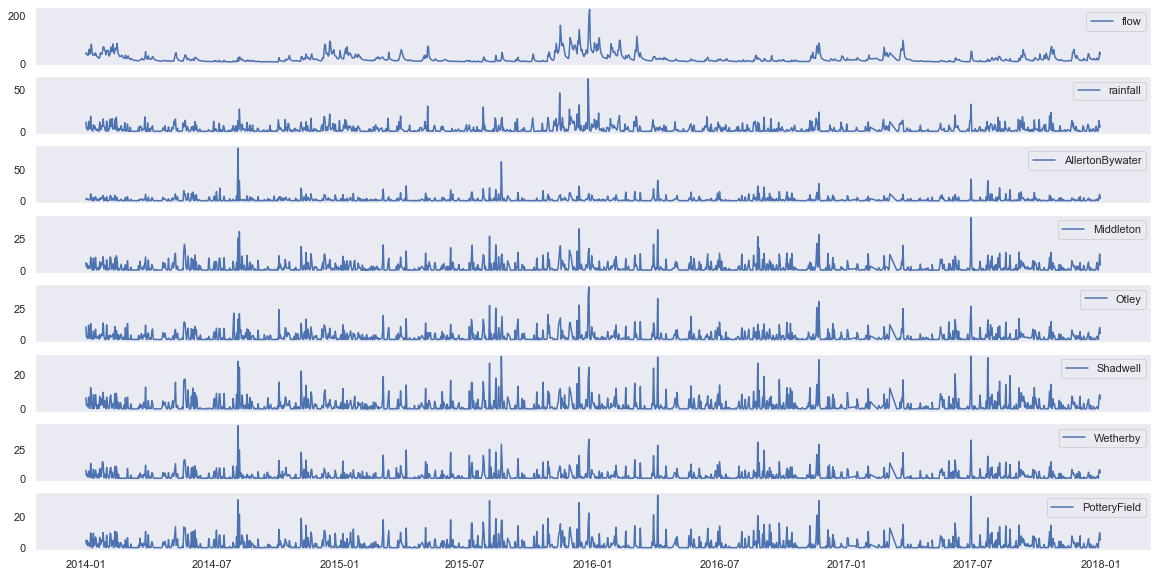

In [5]:
 def format_fig(ax, param, label_text, color_val):
    ax.plot(df_data.index, df_data[param], label = label_text, color = color_val)
    ax.grid()
    ax.legend()
    return ax

_, axs = plt.subplots(8, sharex=True, figsize=(20, 10))
for ax, c in zip(axs, df_data.columns):
#     ax1 = format_fig(ax, 'AllertonBywater', 'Allerton Bywater','b')
    ax.plot(df_data.index, df_data[c], label=c)
    ax.grid()
    ax.legend()

Steal some data processing from that blog post:

In [6]:
df_data.head()

flow  rainfall  AllertonBywater  Middleton  Otley  Shadwell  \
2014-01-01  39.9      10.9              2.4        5.8   10.0       6.4   
2014-01-02  43.5       3.1              3.6        2.4    2.0       2.0   
2014-01-03  35.5       3.8              1.8        5.0    1.4       2.2   
2014-01-04  32.3       1.3              2.0        1.0    0.6       1.2   
2014-01-05  38.3      11.7              1.4        3.2   11.4       6.8   

            Wetherby  PotteryField  
2014-01-01      6.75           4.8  
2014-01-02      2.15           2.2  
2014-01-03      3.30           4.6  
2014-01-04      1.00           1.2  
2014-01-05      6.15           3.2

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler_feat = MinMaxScaler(feature_range=(0, 1))
scaled_feat = scaler_feat.fit_transform(df_data[df_data.columns[1:]].values)

scaler_tar = MinMaxScaler(feature_range=(0, 1))
scaled_tar = scaler_tar.fit_transform(df_data[df_data.columns[0]].values.reshape(len(df_data), 1))

In [8]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [9]:
lag_steps = 6

reframed_in = series_to_supervised(scaled_feat, lag_steps, 1, dropnan=False)
reframed_in = reframed_in[lag_steps:].reset_index(drop=True)

scaled_tar = scaled_tar[lag_steps:,:]
print(reframed_in.shape, scaled_tar.shape)
reframed_in.head()

(1455, 49) (1455, 1)


var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
0   0.173844   0.028846   0.138756   0.239234   0.210526   0.149336   
1   0.049442   0.043269   0.057416   0.047847   0.065789   0.047566   
2   0.060606   0.021635   0.119617   0.033493   0.072368   0.073009   
3   0.020734   0.024038   0.023923   0.014354   0.039474   0.022124   
4   0.186603   0.016827   0.076555   0.272727   0.223684   0.136062   

   var7(t-6)  var1(t-5)  var2(t-5)  var3(t-5)  ...  var5(t-1)  var6(t-1)  \
0   0.142857   0.049442   0.043269   0.057416  ...   0.013158   0.040929   
1   0.065476   0.060606   0.021635   0.119617  ...   0.013158   0.017699   
2   0.136905   0.020734   0.024038   0.023923  ...   0.401315   0.283185   
3   0.035714   0.186603   0.016827   0.076555  ...   0.157895   0.088495   
4   0.095238   0.052632   0.021635   0.047847  ...   0.006579   0.004425   

   var7(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   var5(t)   var6(t)  \
0   0.071428  0.052632  0.014423  0.033493  0.019139  0.013158  0.017699   
1   0.017857  0.283892  0.129808  0.244019  0.306219  0.401315  0.283185   
2   0.279761  0.038278  0.072115  0.172248  0.081340  0.157895  0.088495   
3   0.238095  0.019139  0.002404  0.000000  0.004785  0.006579  0.004425   
4   0.000000  0.003190  0.000000  0.004785  0.004785  0.006579  0.008850   

    var7(t)  
0  0.017857  
1  0.279761  
2  0.238095  
3  0.000000  
4  0.000000  

[5 rows x 49 columns]

In [10]:
sample_split = 0.8

train_X = (reframed_in.values[0:int(sample_split * len(reframed_in.values))])
test_X = (reframed_in.values[int(sample_split * len(reframed_in.values)):])

train_y = (scaled_tar[0:int(sample_split * scaled_tar.shape[0]),:])
test_y = (scaled_tar[int(sample_split * scaled_tar.shape[0]):,:])

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1164, 1, 49) (1164, 1) (291, 1, 49) (291, 1)


Steal the neural network from the other network:

Using TensorFlow backend.


Train on 1164 samples, validate on 291 samples
Epoch 1/50
 - 1s - loss: 0.0512 - val_loss: 0.0293
Epoch 2/50
 - 0s - loss: 0.0465 - val_loss: 0.0250
Epoch 3/50
 - 0s - loss: 0.0446 - val_loss: 0.0254
Epoch 4/50
 - 0s - loss: 0.0434 - val_loss: 0.0246
Epoch 5/50
 - 0s - loss: 0.0421 - val_loss: 0.0241
Epoch 6/50
 - 0s - loss: 0.0409 - val_loss: 0.0239
Epoch 7/50
 - 0s - loss: 0.0397 - val_loss: 0.0233
Epoch 8/50
 - 0s - loss: 0.0385 - val_loss: 0.0237
Epoch 9/50
 - 0s - loss: 0.0374 - val_loss: 0.0235
Epoch 10/50
 - 0s - loss: 0.0363 - val_loss: 0.0233
Epoch 11/50
 - 0s - loss: 0.0353 - val_loss: 0.0236
Epoch 12/50
 - 0s - loss: 0.0345 - val_loss: 0.0234
Epoch 13/50
 - 0s - loss: 0.0337 - val_loss: 0.0236
Epoch 14/50
 - 0s - loss: 0.0331 - val_loss: 0.0236
Epoch 15/50
 - 0s - loss: 0.0325 - val_loss: 0.0242
Epoch 16/50
 - 0s - loss: 0.0321 - val_loss: 0.0244
Epoch 17/50
 - 0s - loss: 0.0317 - val_loss: 0.0246
Epoch 18/50
 - 0s - loss: 0.0314 - val_loss: 0.0246
Epoch 19/50
 - 0s - loss: 

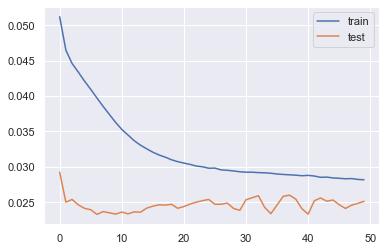

In [11]:
from keras.models import Sequential, model_from_json
from keras.layers import Dense, LSTM

# Design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# Fit network
history = model.fit(
    train_X,
    train_y,
    epochs=50,
    batch_size=72,
    validation_data=(test_X, test_y),
    verbose=2,
    shuffle=False
)

# Plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [12]:
yhat = model.predict(test_X)
xhat = model.predict(train_X)

In [13]:
inv_yhat = scaler_tar.inverse_transform(yhat)
inv_y = scaler_tar.inverse_transform(test_y)

inv_xhat = scaler_tar.inverse_transform(xhat)
inv_x = scaler_tar.inverse_transform(train_y)

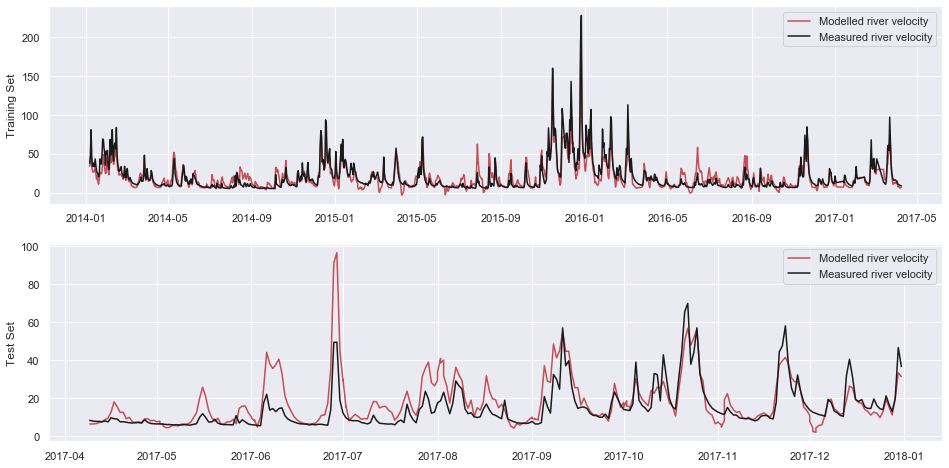

In [16]:
dates = df_data.index[lag_steps:]

train_dates = dates[0:int(sample_split * scaled_tar.shape[0])]
test_dates = dates[int(sample_split * scaled_tar.shape[0]):]

fig, axs = plt.subplots(2, figsize=(16, 8))

axs[0].plot(train_dates, inv_xhat, label='Modelled river velocity', color='r')
axs[0].plot(train_dates, inv_x, label='Measured river velocity', color='k')
axs[0].set_ylabel('Training Set')
axs[0].legend()

axs[1].plot(test_dates, inv_yhat, label='Modelled river velocity', color='r')
axs[1].plot(test_dates, inv_y, label='Measured river velocity', color='k')
axs[1].set_ylabel('Test Set')
axs[1].legend()

Other things:
- Play with the number of lags in the model,
- Other neural network hyperparameter tweaking
    - Learning rate,
    - Epochs,
    - Hidden nodes and layers,
    - Cross-validation